In [7]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)




/Users/gracebelmonte/data_science_tool_box/DataScienceToolbox-Project2/venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/gracebelmonte/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [8]:
import sys
print(sys.executable)


/Users/gracebelmonte/data_science_tool_box/DataScienceToolbox-Project2/venv/bin/python


In [9]:
import torch
device = torch.device("cpu")
print("Using device:", device)


Using device: cpu


In [4]:
print(path)

/Users/gracebelmonte/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [10]:
# check the folder structure 


import os
from pathlib import Path 

dataset_path = Path(path) 

print("Dataset path exists:", dataset_path.exists())
print("Top-level folder/files:")

for item in os.listdir(dataset_path):
    print("-", item)

Dataset path exists: True
Top-level folder/files:
- .DS_Store
- Test
- Test.csv
- Meta
- Train
- Meta.csv
- Train.csv


In [11]:
# check PyTorch # note that my Mac GPU is not active 
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print("MPS available:", torch.backends.mps.is_available())



2.10.0.dev20250929
0.25.0.dev20250929
MPS available: False


In [12]:
import os
from pathlib import Path

dataset_path = Path(path)

train_dir = dataset_path / "Train"
test_dir = dataset_path / "Test"

print("Train folder exists:", train_dir.exists())
print("Test folder exists:", test_dir.exists())


Train folder exists: True
Test folder exists: True


In [13]:
# load the train.csv metadata 

import pandas as pd

train_csv = pd.read_csv(dataset_path / "Train.csv")
test_csv = pd.read_csv(dataset_path / "Test.csv")

train_csv.head()


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


We can see that the images' width and height vary slightly (eg. 27x26, 29x26), this confirms that GTSRB images do not all have the same resolution, which means we must resize them during preprocessing. 
panda function: "https://www.naukri.com/code360/library/import-pandas-as-pd"

In [17]:
# check for missing values 

print("Missing values in training set:")
print(train_csv.isnull().sum())

print("\nMissing values in test set:")
print(test_csv.isnull().sum())



Missing values in training set:
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

Missing values in test set:
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


We can see there are no missing values in either the training or test metadata cvs. 

In [18]:
# analyse class distribution 

# Count images per class
class_counts = train_csv['ClassId'].value_counts().sort_index()

print("Images per class:")
class_counts


Images per class:


ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64

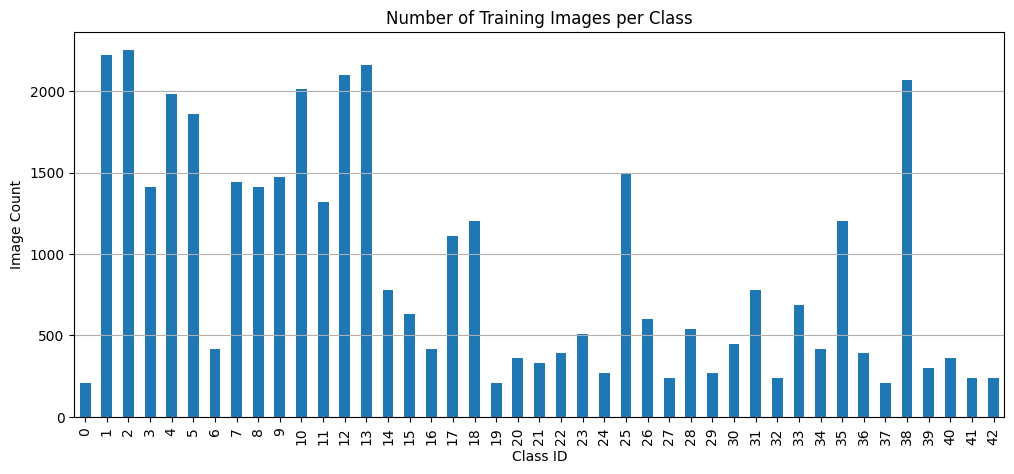

In [128]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
class_counts.plot(kind='bar')
plt.title("Number of Training Images per Class")
plt.xlabel("Class ID")
plt.ylabel("Image Count")
plt.grid(axis='y')
plt.show()


In [19]:
# analyse image sizes

from PIL import Image
import os
sizes = []

for fname in train_csv['Path']:   # the CSV includes image paths
    img_path = dataset_path / fname
    img = Image.open(img_path)
    sizes.append(img.size)

# Show the first 10 sizes
sizes[:10]



[(27, 26),
 (28, 27),
 (29, 26),
 (28, 27),
 (28, 26),
 (31, 27),
 (31, 28),
 (31, 28),
 (31, 29),
 (34, 32)]

In [43]:
# define the preprocessing transforms 

# run this to find the global per channel (R,G,B) mean and std that we should use 

from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


reference = https://docs.pytorch.org/vision/stable/models.html#transforms

We retrived the imageNet mean and sd values bceuase the pre trained models like ResNet 18 expect input images to be normalised using these excat statistics. 

In [21]:
# pre-processing pipeline

from torchvision import transforms

# Standard ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

#train transform and this includes Nevas EDA findings 

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize all images to 224×224
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2), 
    transforms.ToTensor(),           # convert PIL image -> tensor
    transforms.Normalize(imagenet_mean, imagenet_std)
])

#validation test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


ToTensor ref = "https://docs.pytorch.org/vision/main/_modules/torchvision/transforms/transforms.html#ToTensor"
(also from the lab)
Torchvision. 
transformations = "https://docs.pytorch.org/vision/stable/transforms.html"
also data augmentation section from "https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/"

We used ToTensor() as it converts each image from a PIL/ NumPy format into a PyTorch tensor, which is the format required by PyTorch models.  

The augmentations where chosen based on Nevas EDa findings , to simulate real driving conditions. 
And there is no augmentation for validation/test since we only want to masure true model performance, so val/test transforms use only resize, tensor conversion, normalisation. 

This step is helping us prepare the raw GTSRB images for training a CNN/ Transfer learning model. 

In [22]:


# building a pytorch dataset class 

import torch
from torch.utils.data import Dataset
from PIL import Image 
import os 

class GTSRBDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["Path"])
        img = Image.open(img_path).convert("RGB")
        label = row["ClassId"]

        if self.transform:
            img = self.transform(img) #nevas eda augmentation pipeline is applied every time an image is loaded. 

        return img, label


PyTorch requires data to be in speficic format so that DataLoader can load images efficiently hence why this step is necessary.

__init__ (): stores iamge metadata and transforms 
__len__():  tells Pytorch how many samples exist 
__getitem__(): loads one image + its label 


ref for __len__/ __getitem__ : "https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html"

In [14]:

# use Nevas code to reduce the dataset by 50% per class 
from sklearn.model_selection import train_test_split

reduced_train_csv = train_csv.groupby("ClassId").sample(
    frac=0.5,       # keep 50%
    random_state=42
).reset_index(drop=True)

print("Original training images:", len(train_csv))
print("Reduced training images:", len(reduced_train_csv))


Original training images: 39209
Reduced training images: 19604


Here we have reduced the training dataset by 50% per class. This keeps the distribution balanced while significantly reducing training time.

In [15]:
# now split the reduced train set into train/val (80/20)

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    reduced_train_csv,
    test_size=0.2,
    stratify=reduced_train_csv["ClassId"],
    random_state=42
)

print("Train rows:", len(train_df))
print("Val rows  :", len(val_df))



Train rows: 15683
Val rows  : 3921


After reduction, we have split the remaining training images into, 80% training, 20% validation to evalusate model performance during training. 

stratify = train_csv["ClassId"]: ensures each class appears in the same proportion in both train and validation sets. 

Since GTSRB is highly imbalanced ( Neva's class count analysis showed some classes have 210 images while others have 2200+), stratification prevents the validation set from being being biased. 
Without this, the validation set might accidentally contain very few examples from minority classes, causing misleading accuracy (skewed/ biased results).

stratify/ test_size/ random_state = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"

In [23]:
#dataset objects 

root = dataset_path 

train_dataset = GTSRBDataset(train_df, root_dir=root, transform= train_transform)
val_dataset = GTSRBDataset(val_df, root_dir=root, transform=test_transform)
test_dataset = GTSRBDataset(test_csv, root_dir=root, transform=test_transform)



Here, we have connected the CSV metadata and the PyTorch Model. We have applied the augmentation to only the training data, then the validation and test accuracy must reflect real model performance, hence use the non augmented test transform. 

In [24]:
#dataloaders 

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


We have now turned our dataset objects into iterable mini-batches that the neural network can train on.
Each step processes 64 images at once, making training faster and more stable. 
shuffle=True only for training to prevent the model from learning the order of the data.
shuffle/batch size = "https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader"

We have completed Dataset & Preprocessing:

- Dataset loading: train CSV, test CSV, Meta CSV,
- EDA: class distributiom, image size varaition, pixel distribution, random sample visualisation, identifying rotation/ brightness/ blur issues. 
- Preprocessing pipeline: resize -> 224x224, Totensor, nomalisation, augmentation.
- Train/validation/ Test Split.
- Custome Dataset Class ready for Neural Network.
- DatLoaders also ready for a Neural Network.

In [25]:
# Load pretrained ResNet18 Model
from torchvision import models
model = models.resnet18(weights="IMAGENET1K_V1")


We have loaded a ResNet-18 model that has already been trained on the ImageNet dataset. ImageNet has 1.2 million labelled images across 1000 categories. Because of this huge training, Resnet-18 has already learned general features such as edges, textures and simple shapes ect..

ref = "https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html"

The following cells uses code adapted from the Transfer Learning section of: "https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/"

In [21]:
#Freeze all backbone layers 
for param in model.parameters():
    param.requires_grad = False

#replace final layer for 43 traffic sign classes 
model.fc = torch.nn.Linear(model.fc.in_features, 43)


ref for torch.nn.Linear = "https://docs.pytorch.org/vision/stable/_modules/torchvision/models/resnet.html#ResNet18_Weights 
"

We freeze the backbone layers because ResNet 18 already knows how to see edges, colours, textures from being trained on ImageNet. We don't need to retrain all of that, it would take hours. 

Then, we replace the final layer. The original ResNet 18 can classify 1000 ImageNet classes, but our dataset has 43 traffic sign classes. So we simply swap the final layer for a new one that outputs 43 categories instead of 1000. 

In [27]:
import torch.nn as nn 
import torch.optim as optim

#loss function (CrossEntropy = Softmax + NLL combined)
loss_func = nn.CrossEntropyLoss()

#optimiser (only train final layer)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

loss_func = "https://docs.pytorch.org/docs/stable/nn.html#loss-functions"

CrossEntropyLoss is the standard loss for multi-class classification, GTSRB has 43 classes, so this is the appropiate choice. 
Adam updates only the new classifier layer so ResNets learned ImageNet features stay frozen 

In [ ]:
#Resnet-18 Training Loop 
import torch 
from torch.autograd import Variable

epochs = 10  

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:

        #move to CPU (my mac has no GPU)
        images = Variable(images)
        labels = Variable(labels)

        #Zero the gradients of the final layer 
        optimizer.zero_grad()

        #Forward pass
        outputs = model(images)

        #Loss
        loss = loss_func(outputs, labels )

        #Backprop (only final layer updates)
        loss.backward()
        optimizer.step()

        #Track Statistics 
        # accumulate loss and correct predictions
        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    # compute full-dataset train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects / len(train_loader.dataset)

    # VALIDATION 
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_func(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            val_running_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_running_corrects / len(val_loader.dataset)

    # print 4 values
    print(f"Epoch {epoch+1}")
    print(f"Train Loss {train_loss:.4f} | Acc {train_acc:.4f}")
    print(f"Val   Loss {val_loss:.4f} | Acc {val_acc:.4f}")


Epoch 1
Train Loss 2.1613 | Acc 0.4307
Val   Loss 1.5735 | Acc 0.5769
Epoch 2
Train Loss 1.3516 | Acc 0.6188
Val   Loss 1.2599 | Acc 0.6501
Epoch 3
Train Loss 1.1433 | Acc 0.6716
Val   Loss 1.1148 | Acc 0.6738
Epoch 4
Train Loss 1.0109 | Acc 0.7010
Val   Loss 1.0040 | Acc 0.7001
Epoch 5
Train Loss 0.9339 | Acc 0.7217
Val   Loss 0.9624 | Acc 0.7042
Epoch 6
Train Loss 0.8731 | Acc 0.7361
Val   Loss 0.8991 | Acc 0.7348
Epoch 7
Train Loss 0.8325 | Acc 0.7488
Val   Loss 0.9064 | Acc 0.7164
Epoch 8
Train Loss 0.8060 | Acc 0.7491
Val   Loss 0.8436 | Acc 0.7439
Epoch 9
Train Loss 0.7793 | Acc 0.7569
Val   Loss 0.8181 | Acc 0.7447
Epoch 10
Train Loss 0.7630 | Acc 0.7575
Val   Loss 0.8101 | Acc 0.7455


The training and validation accuraxy remain close throughout, showing that the model is learning generalisable features rather than memorising the training set. 
After around Epoch 6-7, improvements slow down, suggesting the model is approaching its performance plateau. 

ref : training section = "https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/"

In [ ]:

#create a file to store learned weights - inform leo of the new name 

torch.save(model.state_dict(), "resnet18_stage1_reduced.pth")





After running the baseline model, we are now going to fine tune. We start by unfreezing the last ResNet 18 Block (layer 4)


In [28]:
# Unfreeze the last ResNet block for fine-tuning
for name, param in model.named_parameters():
    if "layer4" in name:     # last residual block
        param.requires_grad = True
    else:
        param.requires_grad = False


Next we set up two different learning rates.

In [29]:
# two learning-rate optimizer 

classifier_params = list(model.fc.parameters())

layer4_params = [
    p for name, p in model.named_parameters()
    if name.startswith('layer4')
]


optimizer = torch.optim.Adam([
    {"params": model.fc.parameters(), "lr": 1e-3},      # classifier head
    {"params": model.layer4.parameters(), "lr": 1e-4}   # fine-tuned block
])


Next we create learning rate scheduler to automatically reduce the learning rate when the model stops improving. 
And we set up early- stopping variables that will stop the training early when the validation loss gets for for serveral epochs. 

In [30]:
# create the learning rate scheduler 

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


In [31]:
# early stopping variables

best_val_loss = float("inf")
patience = 5
wait = 0
best_model_state = None

Now we will run the fine tuning loop again but with the fine tuning: 

In [ ]:
#fine tuning applied onto resnet loop 

import copy

EPOCHS = 5


for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    model.train()
    running_loss = 0
    running_corrects = 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(1) == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = running_corrects / len(train_loader.dataset)

    #  validation
    model.eval()
    val_running_loss = 0
    val_running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = loss_func(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            val_running_corrects += (outputs.argmax(1) == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_running_corrects / len(val_loader.dataset)

    #scheduler step
    scheduler.step(val_loss)

    print(f"Train Loss {train_loss:.4f} | Acc {train_acc:.4f}")
    print(f"Val   Loss {val_loss:.4f} | Acc {val_acc:.4f}")

    # Early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, "resnet18_best_finetuned.pth")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/5
Train Loss 0.3199 | Acc 0.8968
Val   Loss 0.1476 | Acc 0.9513

Epoch 2/5
Train Loss 0.1161 | Acc 0.9640
Val   Loss 0.1071 | Acc 0.9671

Epoch 3/5
Train Loss 0.0697 | Acc 0.9783
Val   Loss 0.0843 | Acc 0.9725

Epoch 4/5
Train Loss 0.0525 | Acc 0.9841
Val   Loss 0.0728 | Acc 0.9753

Epoch 5/5
Train Loss 0.0338 | Acc 0.9894
Val   Loss 0.0668 | Acc 0.9768


As we can see, fine- tuning produces a very rapid improvement in performance, with the validation accuracy starting above 95% and reaching ~97.7%. 
both training and validation losses decrease smoothly (see plots), showing stable optimisation without signs of overfitting. 
Compared to our baseline model, this fine-tund stage achieves a large improvemnet, confirming that updating the backbone layers in crucial for extracting more detailed traffic-sign features.

In [35]:
#manually creating the history as I had issues with running it again

history = {
    "train_loss": [0.3199, 0.1161, 0.0697, 0.0525, 0.0338],
    "train_acc":  [0.8968, 0.9640, 0.9783, 0.9841, 0.9894],
    "val_loss":   [0.1476, 0.1071, 0.0843, 0.0728, 0.0668],
    "val_acc":    [0.9513, 0.9671, 0.9725, 0.9753, 0.9768]
}


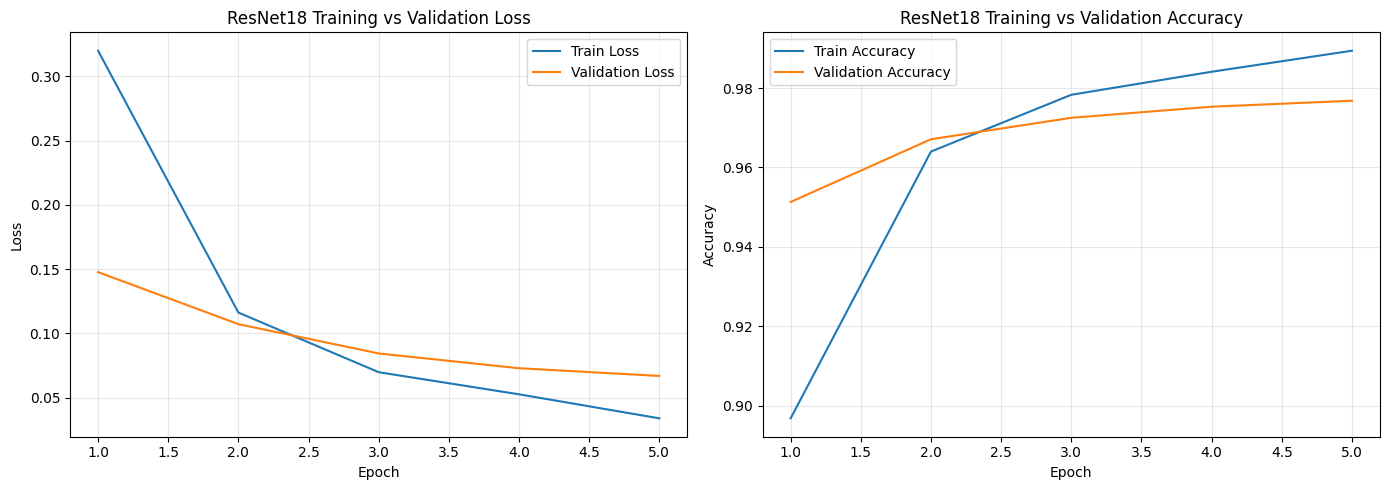

In [36]:

# Visualising Training Curves for ResNet18


import matplotlib.pyplot as plt

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 5))

# ---- Loss Curve ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Validation Loss")
plt.title("ResNet18 Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

# ---- Accuracy Curve ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, history["val_acc"], label="Validation Accuracy")
plt.title("ResNet18 Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Training vs Validation Loss Comments: 
- Both the training loss and validation loss deacrease steadily across epochs, whcih indicates that the model is learning effectively. 
- The validation loss decreases smoothly, suggesting the fine-tuned ResNet 18 generalises well to unseen images. 

Training vs Validation Accuracy Comments: 
- Both training and validation accuracy increase consistently over the 5 epochs. 
- By the fifth epoch, validation accuracy tsabilises at ~0.977, indicating excellent generalisation without signs of overfitting.

In [32]:
import torch
import torch.nn as nn
from torchvision import models

# Recreate architecture
model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze backbone 
for p in model.parameters():
    p.requires_grad = False

# Replace classifier head
model.fc = nn.Linear(model.fc.in_features, 43)

# Load saved fine-tuned weights
model.load_state_dict(torch.load("resnet18_best_finetuned.pth"))
model.eval()

print("Restored model ready for evaluation!")


Restored model ready for evaluation!



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.96      0.95      0.96       222
           2       0.93      0.95      0.94       225
           3       0.94      0.87      0.90       141
           4       0.92      0.98      0.95       198
           5       0.88      0.95      0.91       186
           6       1.00      1.00      1.00        42
           7       0.98      0.97      0.97       144
           8       0.97      0.89      0.93       141
           9       1.00      0.98      0.99       147
          10       0.99      0.99      0.99       201
          11       1.00      0.99      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        78
          15       1.00      1.00      1.00        63
          16       1.00      1.00      1.00        42
   

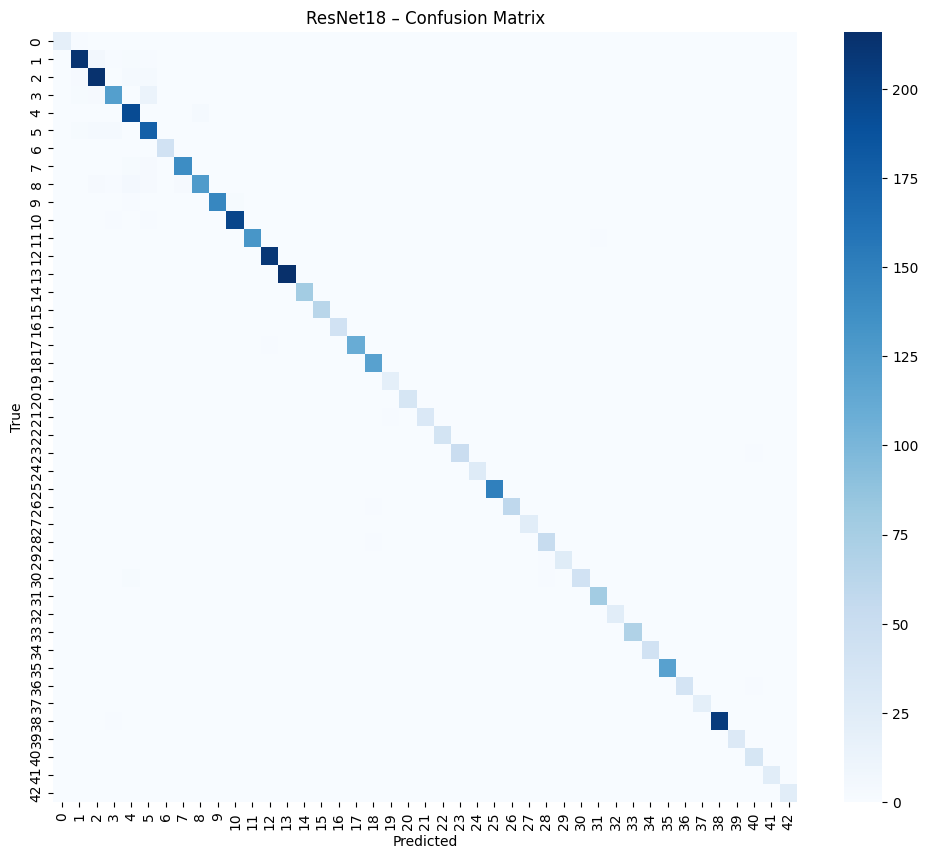

In [33]:
# classification and confusion matrix 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model state (ensures evaluation uses best checkpoint)
model.load_state_dict(torch.load("resnet18_best_finetuned.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("ResNet18 – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


This confusion matric is strongly diagonal, indicating that for almost all classes, the predicted label matches the true labels. This shows a very strong classificiation performance across the 43 traffic sign classes in the GTSRB dataset. 

The overall accuracy of 0.98 from the classification report show that performance is strong even for minority classes, suggesting the downsampled training strategy and fine-tuning approach were effective.

Next we do few shot learning. 

To prepare we first create a function `sample_few_shot` that allows us to subsample the training dataset so that each class contains only k examples. 

We then make a training functions `train_classifier only` that freezes entire ResNet18 backbones and trains only the final classifier layer. The function will return validation accuracy for each few-shot scenario, allowing us to quantify how performance changes as the number of examples per class decreases. 


In [38]:
import numpy as np

def sample_few_shot(df, k):
    """
    Return a dataframe where each class has exactly k samples.
    """
    few_shot_df = df.groupby("ClassId").apply(
        lambda x: x.sample(k, replace=False)
    ).reset_index(drop=True)
    return few_shot_df


In [39]:
def train_classifier_only(model, train_loader, val_loader, epochs=3):
    """
    Train only the final classifier layer for few-shot experiments.
    """

    # Freeze backbone
    for name, param in model.named_parameters():
        if "fc" not in name:   # only classifier head trains
            param.requires_grad = False
            
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        running_corrects = 0
        running_loss = 0

        for imgs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # validation accuracy
        model.eval()
        val_corrects = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                outputs = model(imgs)
                preds = outputs.argmax(1)
                val_corrects += (preds == labels).sum().item()

    val_acc = val_corrects / len(val_loader.dataset)
    return val_acc


In [ ]:
shot_sizes = [1, 5, 10, 20, 40]
results = {}

from torch.utils.data import DataLoader

for k in shot_sizes:
    print(f"\nRunning Few-Shot Learning with {k} samples per class...")

    # sample dataset
    few_df = sample_few_shot(train_df, k)

    # create dataset + loader
    few_train_set = GTSRBDataset(few_df, root_dir=root, transform=train_transform)
    few_train_loader = DataLoader(few_train_set, batch_size=32, shuffle=True)

    #reuse full validation set
    few_val_loader = val_loader

    # reload a fresh model for each experiment
    model_fs = models.resnet18(weights="IMAGENET1K_V1")
    model_fs.fc = nn.Linear(model_fs.fc.in_features, 43)

    # train classifier only
    acc = train_classifier_only(model_fs, few_train_loader, few_val_loader)

    results[k] = acc
    print(f"Validation Accuracy with {k} shots: {acc:.4f}")



Running Few-Shot Learning with 1 samples per class...


/var/folders/z7/0yn3gzs11yv8f0gj13zw3m_w0000gn/T/ipykernel_38744/237494021.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  few_shot_df = df.groupby("ClassId").apply(


Validation Accuracy with 1 shots: 0.0418

Running Few-Shot Learning with 5 samples per class...


/var/folders/z7/0yn3gzs11yv8f0gj13zw3m_w0000gn/T/ipykernel_38744/237494021.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  few_shot_df = df.groupby("ClassId").apply(


Validation Accuracy with 5 shots: 0.0974

Running Few-Shot Learning with 10 samples per class...


/var/folders/z7/0yn3gzs11yv8f0gj13zw3m_w0000gn/T/ipykernel_38744/237494021.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  few_shot_df = df.groupby("ClassId").apply(


Validation Accuracy with 10 shots: 0.1574

Running Few-Shot Learning with 20 samples per class...


/var/folders/z7/0yn3gzs11yv8f0gj13zw3m_w0000gn/T/ipykernel_38744/237494021.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  few_shot_df = df.groupby("ClassId").apply(


Validation Accuracy with 20 shots: 0.2941

Running Few-Shot Learning with 40 samples per class...


/var/folders/z7/0yn3gzs11yv8f0gj13zw3m_w0000gn/T/ipykernel_38744/237494021.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  few_shot_df = df.groupby("ClassId").apply(


Validation Accuracy with 40 shots: 0.3912


There are a few quick observations from these results: 
-  Accuracy increases as you add more examples per class. 
- Performance is extremely low with 1 or 5 shots, the model cannot generalised well when the classifier head is trained on such tiny data. 
- The growth is smooth, not flat (see curve below). This clarifies a key point that more data per class = better accuracy, thus confirms the value and necessity of finetuning with more samples. 

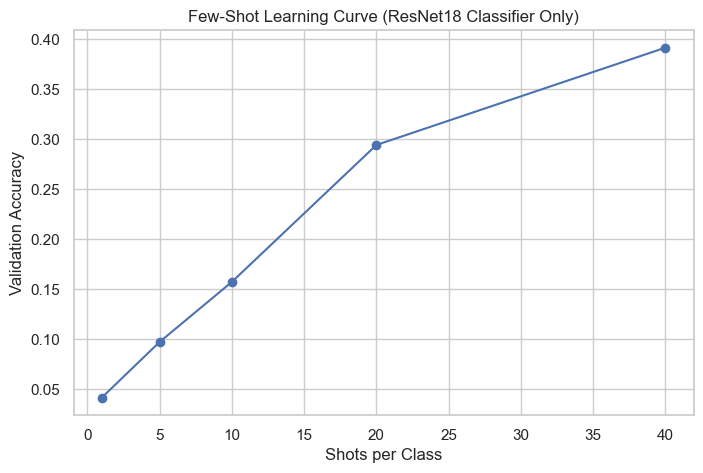

In [41]:
import matplotlib.pyplot as plt

shots = list(results.keys())
accs = [results[k] for k in shots]

plt.figure(figsize=(8,5))
plt.plot(shots, accs, marker='o')
plt.title("Few-Shot Learning Curve (ResNet18 Classifier Only)")
plt.xlabel("Shots per Class")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()
